In [181]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from scipy import stats
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import matplotlib.ticker as ticker
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import math
import re
import warnings
import sys
warnings.filterwarnings('ignore')


In [182]:
#Step 1:Read the Houston electricity price data and upload it to a Data frame from ERCOT

#Electricity Prices in Houston for 2022, 2023, and 2024 
Houston_electricity_prices = pd.read_csv('Data\\Houston_electricity_prices.csv')
#We filter the electricity prices by SettlementPoint for Houston Hub
Houston_electricity_prices = Houston_electricity_prices[Houston_electricity_prices['SettlementPoint'] =='HB_HOUSTON'].reset_index()

#Power Demand in Houston for 2022, 2023, and 2024
Power_Demand = pd.read_csv('Data\\Demand_electricity.csv')
#We filter the power demand by Houston
Power_Demand = Power_Demand[Power_Demand['HOUSTON'] != 'HOUSTON'].reset_index()

#Solar supply in Houston for 2022, 2023, and 2024
Solar_supply = pd.read_csv('Data\\Solar_supply.csv')

#Wind supply in Houston for 2022, 2023, and 2024
Wind_supply = pd.read_csv('Data\\Wind_supply.csv')

In [183]:
#We merged all the dataframes in one unique dataframe by adding the Demand, Wind and Solar columns.

print(Houston_electricity_prices.shape)
print(Power_Demand.shape)
print(Solar_supply.shape)
print(Wind_supply.shape)

#Merging electricity prices with Power demand
Houston_electricity_prices['DEMAND_HOUSTON'] = Power_Demand['HOUSTON'] 
Houston_electricity_prices['WIND_SUPPLY'] = Solar_supply['ACTUAL_SYSTEM_WIDE'] 
Houston_electricity_prices['SOLAR_SUPPLY'] = Wind_supply['ACTUAL_SYSTEM_WIDE'] 
Houston_electricity_prices = Houston_electricity_prices.drop(labels=['index'], axis=1)
Houston_electricity_prices

(26302, 6)
(26302, 9)
(26302, 7)
(26302, 19)


,DeliveryDate,HourEnding,SettlementPoint,SettlementPointPrice,DSTFlag,DEMAND_HOUSTON,WIND_SUPPLY,SOLAR_SUPPLY
0,1/1/2022,0:00,HB_HOUSTON,25.18,N,10795.38,0.46,21548.49
1,1/1/2022,1:00,HB_HOUSTON,33.20,N,11186.78,0.12,12067.40
2,1/1/2022,2:00,HB_HOUSTON,25.65,N,10950.95,0.11,12886.02
3,1/1/2022,3:00,HB_HOUSTON,23.01,N,10621.37,0.11,14369.45
4,1/1/2022,4:00,HB_HOUSTON,18.56,N,10469.91,0.12,16467.65
...,...,...,...,...,...,...,...,...
26297,12/31/2024,19:00,HB_HOUSTON,35.50,N,11599.95,0.60,5212.03
26298,12/31/2024,20:00,HB_HOUSTON,32.47,N,11253.06,0.61,7348.58
26299,12/31/2024,21:00,HB_HOUSTON,30.35,N,10910.36,0.68,8892.24
26300,12/31/2024,22:00,HB_HOUSTON,24.81,N,10623.06,0.68,10500.98


In [184]:
#Step 2: Inspect the dataframe to resolve Structural Errors
print("Data Frame Price structure")
print(Houston_electricity_prices.dtypes)

Data Frame Price structure
DeliveryDate             object
HourEnding               object
SettlementPoint          object
SettlementPointPrice    float64
DSTFlag                  object
DEMAND_HOUSTON          float64
WIND_SUPPLY             float64
SOLAR_SUPPLY            float64
dtype: object


In [185]:
#Change the data type of the price column from string to float
Houston_electricity_prices['SettlementPointPrice'] = Houston_electricity_prices['SettlementPointPrice'].astype(float)


In [186]:
#Change the data type of the hourending column from string to float
Houston_electricity_prices['HourEnding'] = pd.to_datetime(Houston_electricity_prices['HourEnding'], format='%H:%M').dt.hour
Houston_electricity_prices['HourEnding'] = Houston_electricity_prices['HourEnding'].astype(float)

In [187]:
#Change the data type of the DeliveryDate column from string to Date
Houston_electricity_prices['DeliveryDate'] = pd.to_datetime(Houston_electricity_prices['DeliveryDate'],format='%m/%d/%Y')

#We have completed our initial dataset. Now we need to search for data imperfections

In [188]:
#Step 3: Data cleansing - Identify any empty fields in the data frames


empty_fields = Houston_electricity_prices.isna() | (Houston_electricity_prices == '')
#print(empty_fields)

empty_count_per_column = empty_fields.sum()
print(empty_count_per_column)

#We observed no empty fields to clean from ERCOT data

DeliveryDate            0
HourEnding              0
SettlementPoint         0
SettlementPointPrice    0
DSTFlag                 0
DEMAND_HOUSTON          0
WIND_SUPPLY             0
SOLAR_SUPPLY            0
dtype: int64


In [189]:
#Step 4: We will analyze the Houston electricity price behavior during the year before understanding the autoregressive models

#Analysis of Houston Electricity price per year

#Add a new columns to keep the year, month, and date of each date
Houston_electricity_prices['Year'] = Houston_electricity_prices['DeliveryDate'].dt.year
Houston_electricity_prices['month'] = Houston_electricity_prices['DeliveryDate'].dt.month_name()
Houston_electricity_prices['day'] = Houston_electricity_prices['DeliveryDate'].dt.day
Houston_electricity_prices['DayandMonth'] = Houston_electricity_prices['DeliveryDate'].dt.strftime('%m/%d')
Houston_electricity_prices

,DeliveryDate,HourEnding,SettlementPoint,SettlementPointPrice,DSTFlag,DEMAND_HOUSTON,WIND_SUPPLY,SOLAR_SUPPLY,Year,month,day,DayandMonth
0,2022-01-01,0.0,HB_HOUSTON,25.18,N,10795.38,0.46,21548.49,2022,January,1,01/01
1,2022-01-01,1.0,HB_HOUSTON,33.20,N,11186.78,0.12,12067.40,2022,January,1,01/01
2,2022-01-01,2.0,HB_HOUSTON,25.65,N,10950.95,0.11,12886.02,2022,January,1,01/01
3,2022-01-01,3.0,HB_HOUSTON,23.01,N,10621.37,0.11,14369.45,2022,January,1,01/01
4,2022-01-01,4.0,HB_HOUSTON,18.56,N,10469.91,0.12,16467.65,2022,January,1,01/01
...,...,...,...,...,...,...,...,...,...,...,...,...
26297,2024-12-31,19.0,HB_HOUSTON,35.50,N,11599.95,0.60,5212.03,2024,December,31,12/31
26298,2024-12-31,20.0,HB_HOUSTON,32.47,N,11253.06,0.61,7348.58,2024,December,31,12/31
26299,2024-12-31,21.0,HB_HOUSTON,30.35,N,10910.36,0.68,8892.24,2024,December,31,12/31
26300,2024-12-31,22.0,HB_HOUSTON,24.81,N,10623.06,0.68,10500.98,2024,December,31,12/31


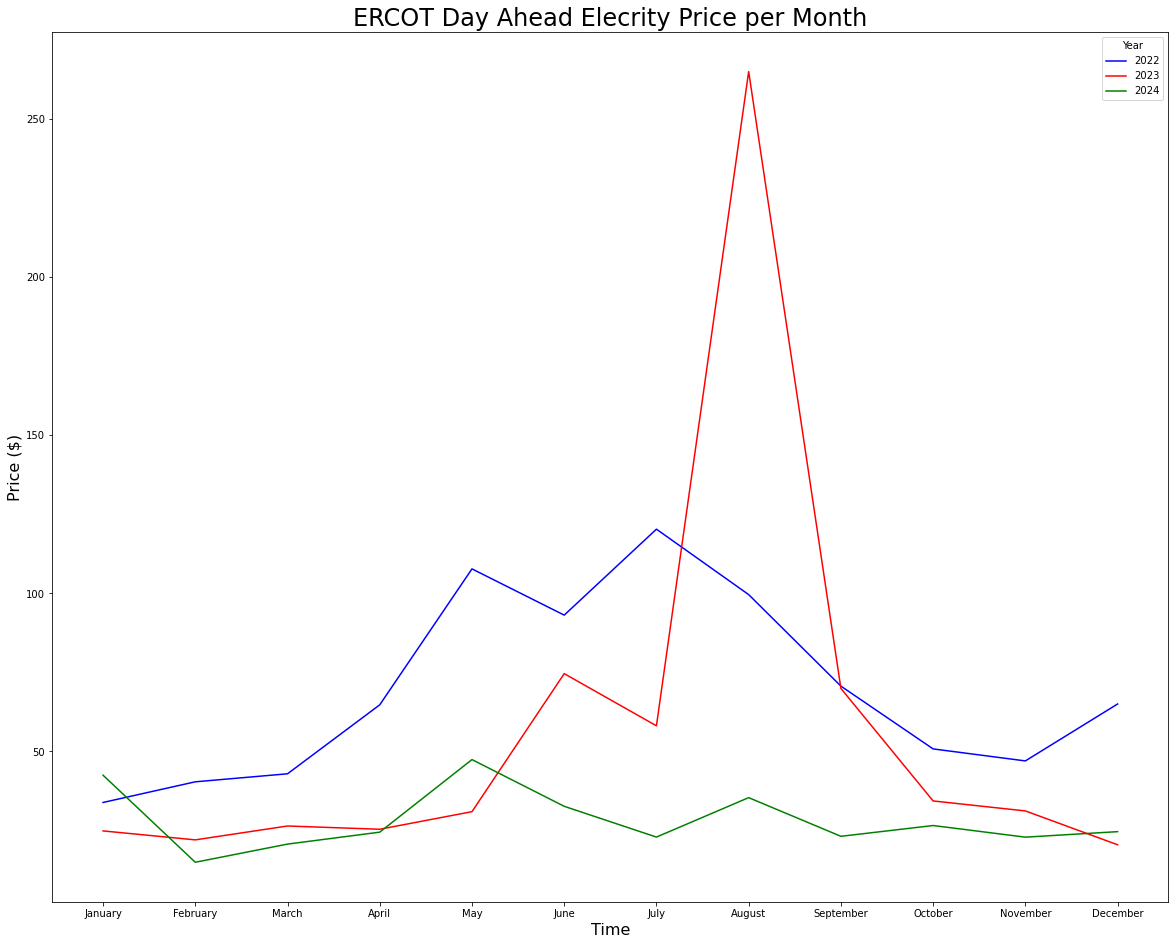

In [190]:
#Analysis of Houston Electricity price per month and year

# Create the line plot
plt.figure(figsize=(20, 16))
sns.lineplot(x='month', y='SettlementPointPrice', hue='Year', palette=['blue', 'red','green'],data=Houston_electricity_prices, ci=None)

# Add title and labels
plt.title('ERCOT Day Ahead Elecrity Price per Month', fontsize=24)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)

# Show the plot
plt.show()

#From the figue below, price data shows clear seasonality change in the value of the peaks. These were due to weather factors and the heat wave leading to increased demand and as a result prices. For instance, in summer, we observed higher prices from May to August when the demand of energy increases.
#We need more granular analysis to define the right features for this model.

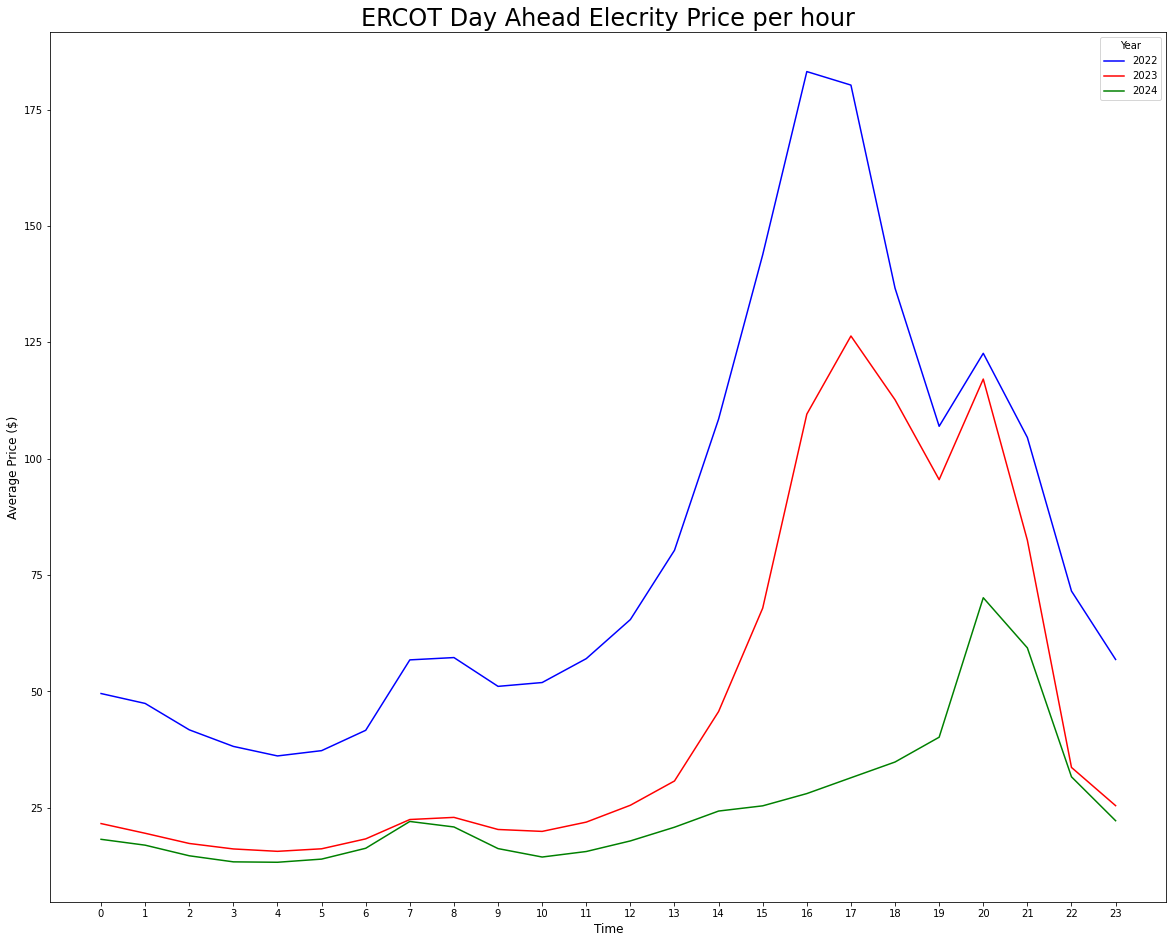

In [191]:
#Analysis of Houston Electricity price per hour

filtered_df = Houston_electricity_prices.query('(month == "March") or (month == "April") or (month == "June") or (month == "July")')
    
Hourly_Dataframe=filtered_df.groupby(['HourEnding', 'Year'])['SettlementPointPrice'].mean().reset_index()

# Create the line plot
plt.figure(figsize=(20, 16))
sns.lineplot(x='HourEnding', y='SettlementPointPrice', hue='Year', palette=['blue', 'red','green'],data=Hourly_Dataframe, ci=None)

# Add title and labels
plt.title('ERCOT Day Ahead Elecrity Price per hour', fontsize=24)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.show()

#The HB Houston price doubled peak is in the evenings at 4:00 p.m. and 7:00 p.m.The forecast model is required to capture these peaks.
#The price is clearly hour dependent. We therefore must use the built-in Hour feature

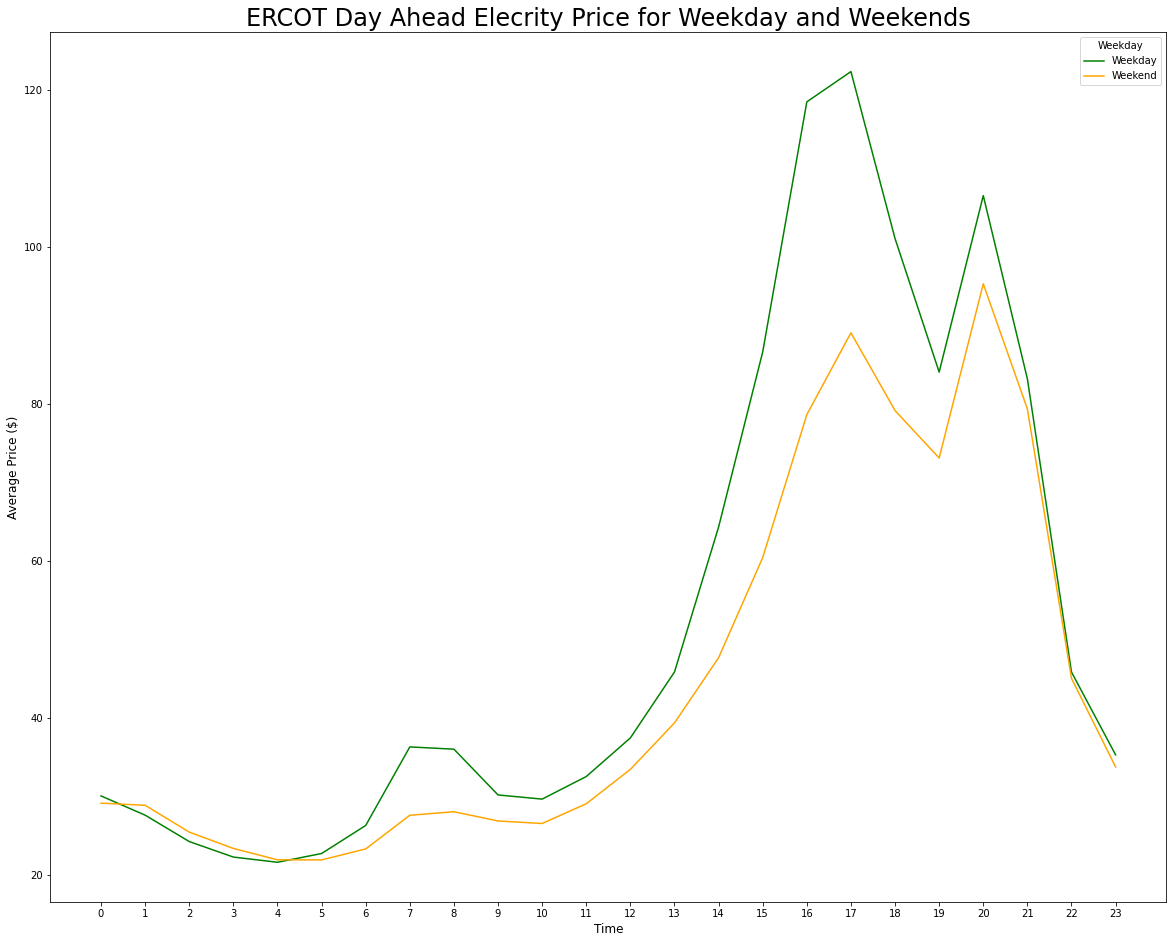

In [192]:
#We can further refine the above analysis by drilling down to days of the week. 
#The next plot displays the average hourly price for weekday and weekends, computed for the 4-month training data.

def is_weekday(date):
    if date.weekday() < 5:
        return 'Weekday'
    else:
        return 'Weekend'

filtered_df['Weekday'] = filtered_df['DeliveryDate'].apply(is_weekday)
Hourly_Dataframe=filtered_df.groupby(['HourEnding', 'Year', 'Weekday'])['SettlementPointPrice'].mean().reset_index()



# Create the line plot
plt.figure(figsize=(20, 16))
sns.lineplot(x='HourEnding', y='SettlementPointPrice', hue='Weekday', palette=['green', 'orange'],data=Hourly_Dataframe, ci=None)

# Add title and labels
plt.title('ERCOT Day Ahead Elecrity Price for Weekday and Weekends', fontsize=24)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.show()

#From the diagram below
#1. The pattern of data is almost the same in terms of hours of the peaks in different days of the week.
#2  The weekdays have different levels of price data in the peak area.

In [193]:
#These observations lead to the following feature engineering configuration of our AI Price Forecast model:
#1. Weekday and Week Number as built-in features or predictors to the AI Model to indicate the days of the week.
#2. Hour and Is Working Day built-in to reflect other patterns within a day.
#3. Year as a built-in feature or predictor to the ML Model to indicate the year.

In [194]:
#Step 5: Our model will have the following variables

#Lagged Variables - Previous Price (which is the previous hour electricity price)
#Built-in Predictors - Hour, Weekday (with dummies), Week Number, Month, Is Working Day.
#External Time Series Predictors - Demand forecast, Wind forecast, and Solar forecast

#We add the Previous price to the Dataframe.
Houston_electricity_prices['Previous_SettlementPointPrice'] = Houston_electricity_prices['SettlementPointPrice'].shift(1)

#We add the Weekday field to the Dataframe.
def weekday(date):
    return date.weekday()

Houston_electricity_prices['Weekday'] = Houston_electricity_prices['DeliveryDate'].apply(weekday)

#We add the Week number field to the Dataframe.
Houston_electricity_prices['Week_number'] = Houston_electricity_prices['DeliveryDate'].dt.isocalendar().week

#We add the Is Workday field to the Dataframe.
def Is_Workingday(date):
    if date.weekday() < 5:
        return 1
    else:
        return 0
Houston_electricity_prices['Is_Working_Day'] = Houston_electricity_prices['DeliveryDate'].apply(Is_Workingday)

#Hour and Month are already created.
Houston_electricity_prices = Houston_electricity_prices.rename(columns={'HourEnding': 'Hour'})
Houston_electricity_prices.reset_index()
#print(type(Houston_electricity_prices))
#Houston_electricity_prices = Houston_electricity_prices.drop(['index'], axis=1, inplace=True)

,index,DeliveryDate,Hour,SettlementPoint,SettlementPointPrice,DSTFlag,DEMAND_HOUSTON,WIND_SUPPLY,SOLAR_SUPPLY,Year,month,day,DayandMonth,Previous_SettlementPointPrice,Weekday,Week_number,Is_Working_Day
0,0,2022-01-01,0.0,HB_HOUSTON,25.18,N,10795.38,0.46,21548.49,2022,January,1,01/01,NaN,5,52,0
1,1,2022-01-01,1.0,HB_HOUSTON,33.20,N,11186.78,0.12,12067.40,2022,January,1,01/01,25.18,5,52,0
2,2,2022-01-01,2.0,HB_HOUSTON,25.65,N,10950.95,0.11,12886.02,2022,January,1,01/01,33.20,5,52,0
3,3,2022-01-01,3.0,HB_HOUSTON,23.01,N,10621.37,0.11,14369.45,2022,January,1,01/01,25.65,5,52,0
4,4,2022-01-01,4.0,HB_HOUSTON,18.56,N,10469.91,0.12,16467.65,2022,January,1,01/01,23.01,5,52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26297,26297,2024-12-31,19.0,HB_HOUSTON,35.50,N,11599.95,0.60,5212.03,2024,December,31,12/31,44.53,1,1,1
26298,26298,2024-12-31,20.0,HB_HOUSTON,32.47,N,11253.06,0.61,7348.58,2024,December,31,12/31,35.50,1,1,1
26299,26299,2024-12-31,21.0,HB_HOUSTON,30.35,N,10910.36,0.68,8892.24,2024,December,31,12/31,32.47,1,1,1
26300,26300,2024-12-31,22.0,HB_HOUSTON,24.81,N,10623.06,0.68,10500.98,2024,December,31,12/31,30.35,1,1,1


(0.0, 500.0)

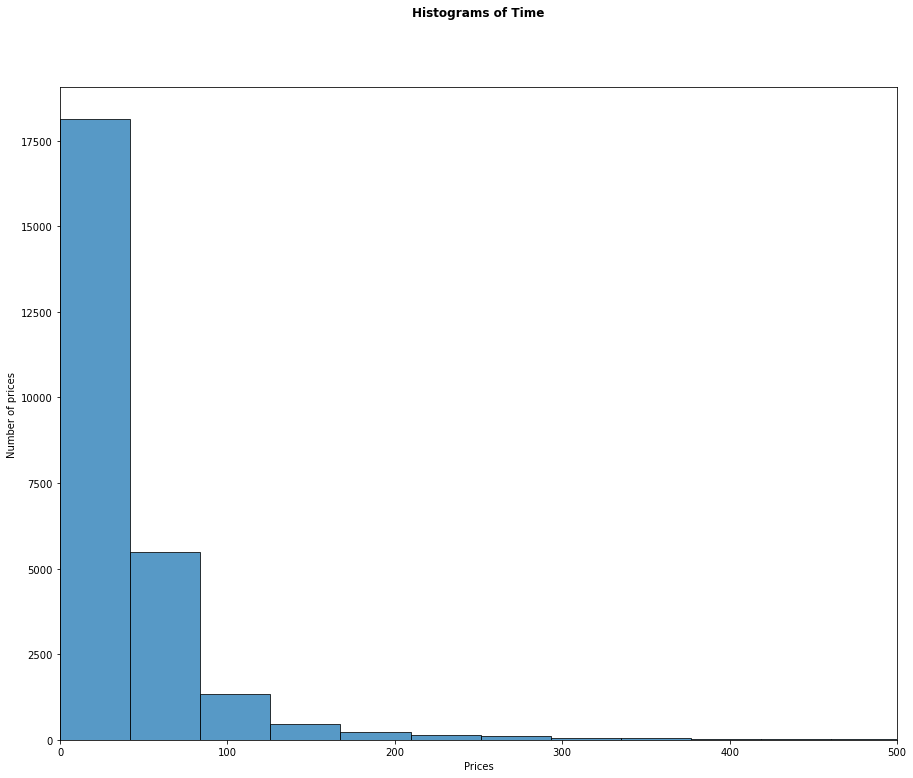

In [195]:
#Step 6: Saving our base data set with relevant fields for the model
Houston_electricity_prices_base = Houston_electricity_prices[['DeliveryDate','Hour','SettlementPointPrice','Previous_SettlementPointPrice','Weekday','Week_number','month','Year','Is_Working_Day']]

#Rename the columns to facilitate the dataframe manipulation
Houston_electricity_prices_base = Houston_electricity_prices_base.rename(columns={'SettlementPointPrice': 'EPrice'})
Houston_electricity_prices_base = Houston_electricity_prices_base.rename(columns={'Previous_SettlementPointPrice': 'Prev_Price'})
Houston_electricity_prices_base = Houston_electricity_prices_base.rename(columns={'Week_number': 'Week_number'})
Houston_electricity_prices_base = Houston_electricity_prices_base.rename(columns={'month': 'Month'})

#Preparing dummy variables for Weekday
unique_values, index_positions = np.unique(Houston_electricity_prices_base['Weekday'], return_index=True)
dummies = pd.get_dummies(Houston_electricity_prices_base['Weekday'])
dummies.iloc[index_positions,:]
Houston_electricity_prices_base = pd.concat([Houston_electricity_prices_base,dummies], axis = 1)
Houston_electricity_prices_base.columns = ['DeliveryDate', 'Hour','EPrice','Prev_Price','Weekday','Week_number','Month','Year','Is_Working_Day','Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
Houston_electricity_prices_base =Houston_electricity_prices_base.drop('Weekday', axis=1)


#Now we drop Wednesday dummy column to avoid multicolinearity
Houston_electricity_prices_base =Houston_electricity_prices_base.drop('Wednesday', axis=1)

Houston_electricity_prices_base.dtypes

#Now, we need to exclude the outliers. The only field with possible outliers is the EPrice and Prev_EPrice

#Step 6.1: Price - We prepare a histogram and notice that we have outliers for prices. 

plt.figure(figsize=(15, 12))
ax = sns.histplot(data=Houston_electricity_prices_base, x="EPrice",bins=100)
plt.xlabel("Prices")
plt.ylabel("Number of prices")
plt.title("Histograms of Time", fontweight='bold', y=1.1)
plt.ylim(0, max(plt.ylim())) 
plt.xlim(0, 500)

#Per simple observation, we observe that any price above US$ 100 dollars is an outlier.

In [196]:
#Step 7: We remove the outlier prices above US$100

grouped_mean = Houston_electricity_prices_base.groupby('Year')['EPrice'].mean().reset_index()

Houston_electricity_prices_base.loc[(Houston_electricity_prices_base['Year'] == 2022) & (Houston_electricity_prices_base['EPrice'] > 100), 'EPrice'] = grouped_mean['EPrice'].iloc[0]
Houston_electricity_prices_base.loc[(Houston_electricity_prices_base['Year'] == 2023) & (Houston_electricity_prices_base['EPrice'] > 100), 'EPrice'] = grouped_mean['EPrice'].iloc[1]
Houston_electricity_prices_base.loc[(Houston_electricity_prices_base['Year'] == 2024) & (Houston_electricity_prices_base['EPrice'] > 100), 'EPrice'] = grouped_mean['EPrice'].iloc[2]
Houston_electricity_prices_base

#Step 7.1: We update Prev_Price to remove outliers

Houston_electricity_prices_base['Prev_Price'] = Houston_electricity_prices_base['EPrice'].shift(1)
Houston_electricity_prices_base = Houston_electricity_prices_base.drop(0)

#Step 7.2: We apply the log function to Prices fields and convert Months field to numbers
Houston_electricity_prices_base['EPrice'] = np.log10(Houston_electricity_prices_base['EPrice'])
Houston_electricity_prices_base['Prev_Price'] = np.log10(Houston_electricity_prices_base['Prev_Price'])
Houston_electricity_prices_base['Month'] = pd.to_datetime(Houston_electricity_prices_base['Month'], format='%B').dt.strftime('%m').astype(float)
Houston_electricity_prices_base

Houston_electricity_prices_base


,DeliveryDate,Hour,EPrice,Prev_Price,Week_number,Month,Year,Is_Working_Day,Monday,Tuesday,Thursday,Friday,Saturday,Sunday
1,2022-01-01,1.0,1.521138,1.401056,52,1.0,2022,0,0,0,0,0,1,0
2,2022-01-01,2.0,1.409087,1.521138,52,1.0,2022,0,0,0,0,0,1,0
3,2022-01-01,3.0,1.361917,1.409087,52,1.0,2022,0,0,0,0,0,1,0
4,2022-01-01,4.0,1.268578,1.361917,52,1.0,2022,0,0,0,0,0,1,0
5,2022-01-01,5.0,1.105169,1.268578,52,1.0,2022,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26297,2024-12-31,19.0,1.550228,1.648653,1,12.0,2024,1,0,1,0,0,0,0
26298,2024-12-31,20.0,1.511482,1.550228,1,12.0,2024,1,0,1,0,0,0,0
26299,2024-12-31,21.0,1.482159,1.511482,1,12.0,2024,1,0,1,0,0,0,0
26300,2024-12-31,22.0,1.394627,1.482159,1,12.0,2024,1,0,1,0,0,0,0


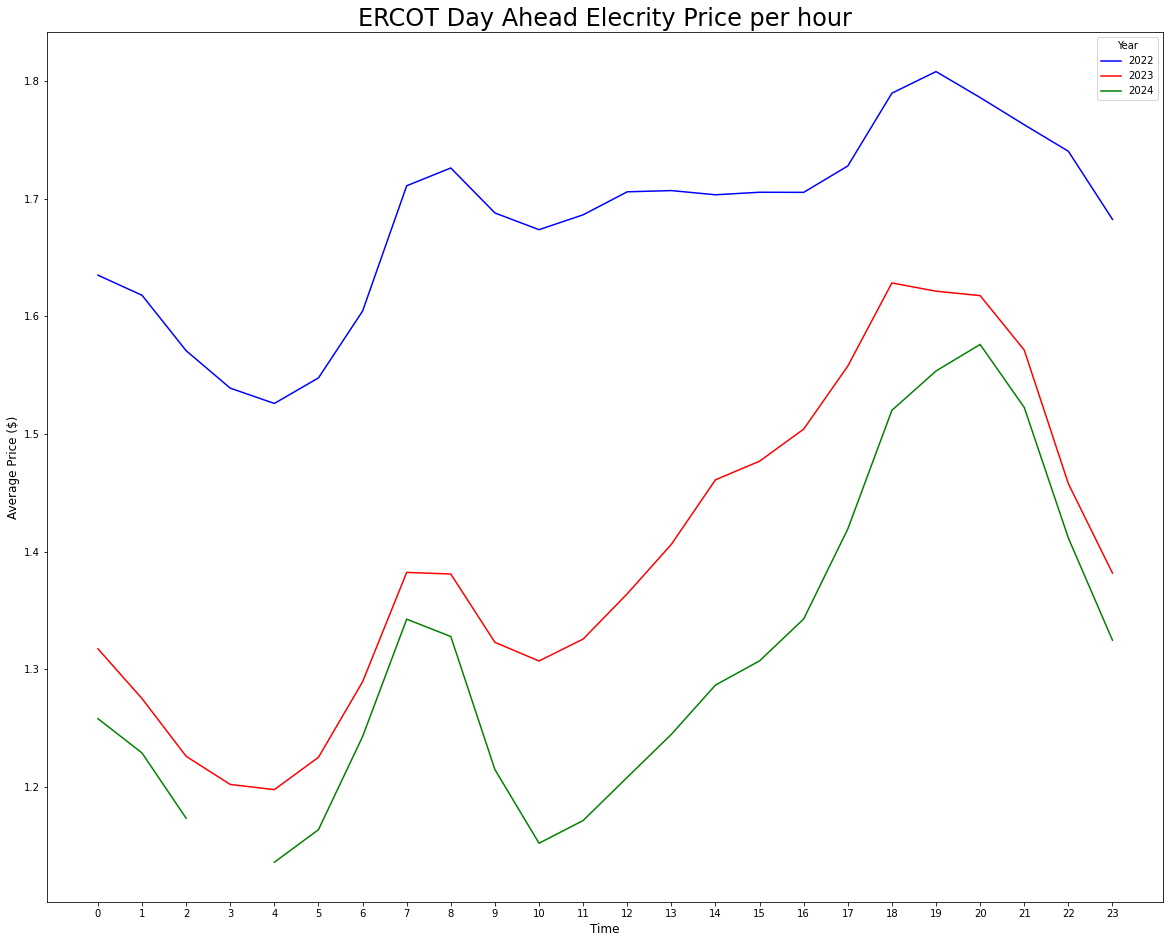

In [197]:
# Create the line plot
plt.figure(figsize=(20, 16))
sns.lineplot(x='Hour', y='EPrice', hue='Year', palette=['blue', 'red','green'],data=Houston_electricity_prices_base, ci=None)

# Add title and labels
plt.title('ERCOT Day Ahead Elecrity Price per hour', fontsize=24)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.show()

#From the diagram below, we do not have any outliers on price.

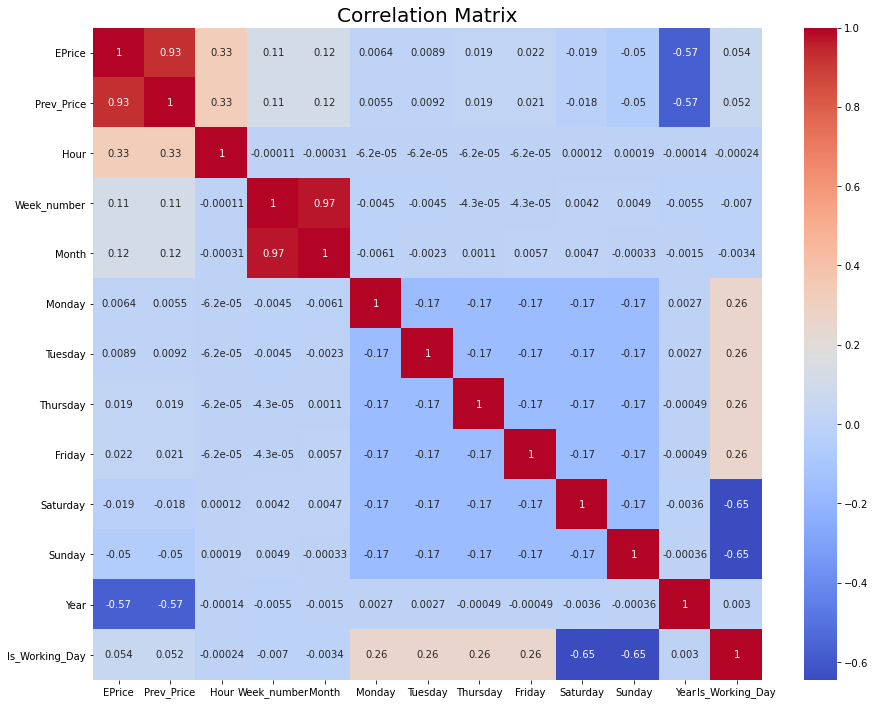

In [198]:
#Step 8: We will quickly inspect the correlation values for the variables with a heatmap

corr_matrix = Houston_electricity_prices_base[['EPrice','Prev_Price','Hour','Week_number','Month','Monday','Tuesday','Thursday','Friday','Saturday','Sunday','Year','Is_Working_Day']].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix',  fontsize=20)
plt.show()

#Houston_electricity_prices_base

In [199]:
#After all the log transformations on Prices, we clean the Electricity Prices to prevent NaN or Inf values

Houston_electricity_prices_base['EPrice'].replace([np.inf, -np.inf], np.nan, inplace=True)
Houston_electricity_prices_base['Prev_Price'].replace([np.inf, -np.inf], np.nan, inplace=True)

Houston_electricity_prices_base=Houston_electricity_prices_base.dropna()

rows_with_nan_inf = Houston_electricity_prices_base[Houston_electricity_prices_base.isna().any(axis=1) ]

print(rows_with_nan_inf)

#The Price columns are clean now with no NaN values. 

Empty DataFrame
Columns: [DeliveryDate, Hour, EPrice, Prev_Price, Week_number, Month, Year, Is_Working_Day, Monday, Tuesday, Thursday, Friday, Saturday, Sunday]
Index: []


Correlation between Prices and Hour: 0.33025733617788916
P_value: 0.0
Is this relationship significant? Yes


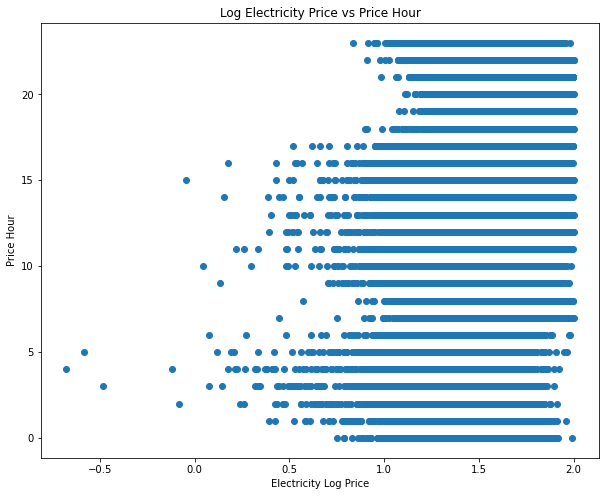

In [200]:
#Step 9: We will apply the p value test to confirm a meaningful correlation with price.

#P-test between EPrice and Hour correlation_coefficient
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Hour'])

if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Hour'])

# Add labels and title
plt.xlabel("Electricity Log Price")
plt.ylabel("Price Hour")
plt.title("Log Electricity Price vs Price Hour")    
    
    
print("Correlation between Prices and Hour: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))


Correlation between Prices and Hour: 0.9252474697697922
P_value: 0.0
Is this relationship significant? Yes


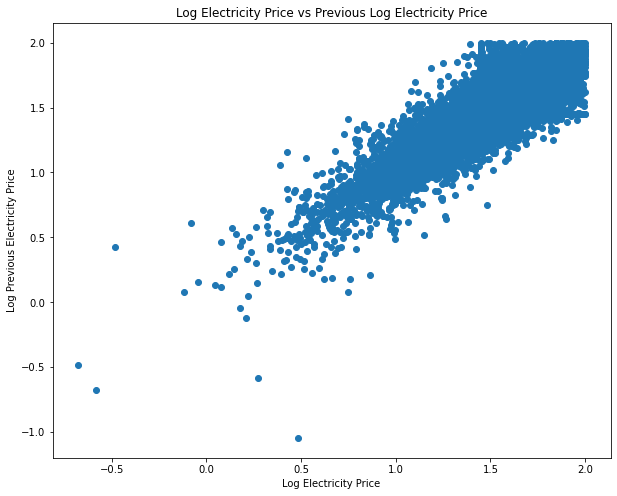

In [201]:
#P-test between EPrice and Prev_Price correlation_coefficient

correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Prev_Price'])

if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Prev_Price'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Log Previous Electricity Price")
plt.title("Log Electricity Price vs Previous Log Electricity Price")    
    
    
print("Correlation between Prices and Hour: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))



Correlation between Prices and Week_number: 0.11491624340820332
P_value: 5.271034712719579e-78
Is this relationship significant? Yes


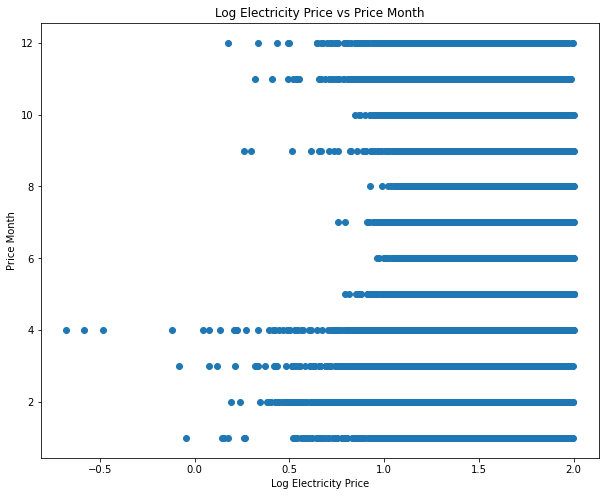

In [202]:
#P-test between EPrice and Month correlation_coefficient
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Month'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Month'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Price Month")
plt.title("Log Electricity Price vs Price Month")    
    
print("Correlation between Prices and Week_number: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))


Correlation between Prices and Week_number: 0.1143271547234746
P_value: 3.202582965989139e-77
Is this relationship significant? Yes


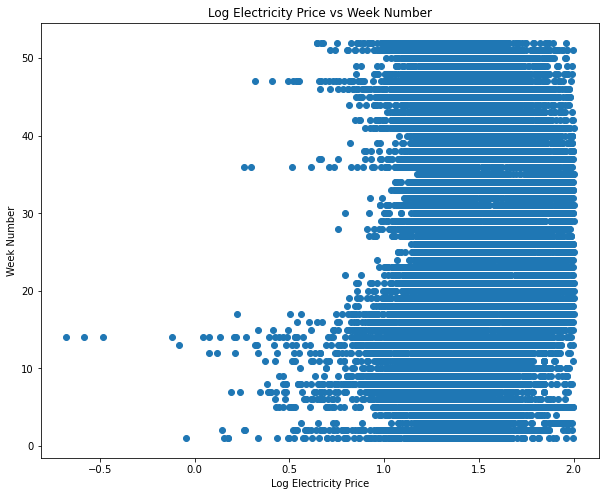

In [203]:
#P-test between EPrice and Week_number correlation_coefficient
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Week_number'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"


plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Week_number'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Week Number")
plt.title("Log Electricity Price vs Week Number")        
    
print("Correlation between Prices and Week_number: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))



Correlation between Prices and Year: -0.5693874761792075
P_value: 0.0
Is this relationship significant? Yes


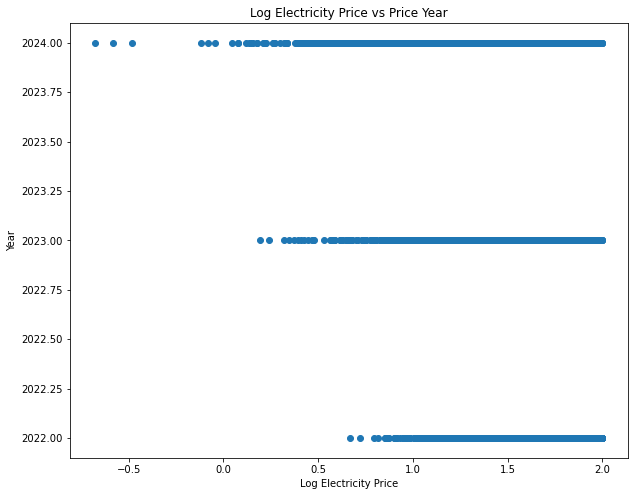

In [204]:
#P-test between EPrice and Year
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Year'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Year'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Year")
plt.title("Log Electricity Price vs Price Year") 
    
print("Correlation between Prices and Year: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))



Correlation between Prices and Is_Working_Day: 0.05425756097355165
P_value: 1.310503425232407e-18
Is this relationship significant? Yes


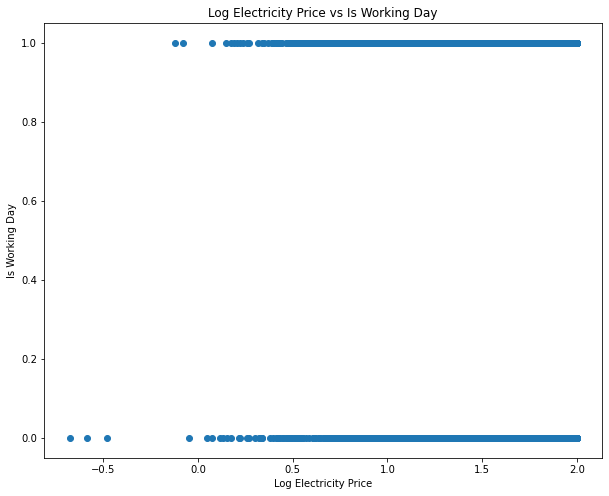

In [205]:
#P-test between EPrice and Is_Working_day
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Is_Working_Day'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Is_Working_Day'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Is Working Day")
plt.title("Log Electricity Price vs Is Working Day")
    
print("Correlation between Prices and Is_Working_Day: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))


Correlation between Prices and Monday: 0.006300517627099947
P_value: 0.3069252898741808
Is this relationship significant? We cannot confirm or disregad the significancy


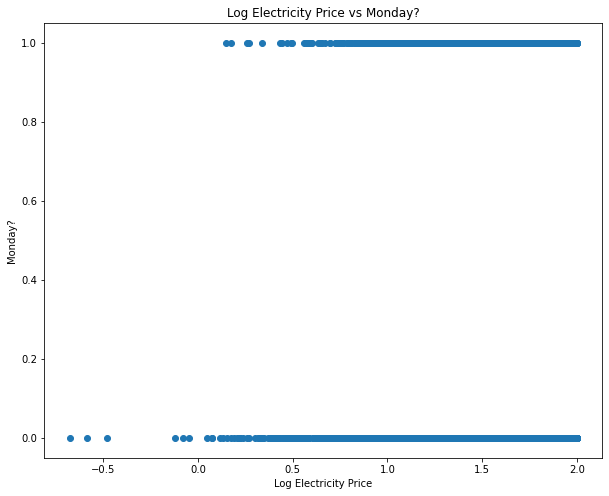

In [206]:
#P-test between EPrice and Monday
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Monday'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Monday'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Monday?")
plt.title("Log Electricity Price vs Monday?")
   
print("Correlation between Prices and Monday: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))


Correlation between Prices and Tuesday: 0.008744944553132412
P_value: 0.15616231174116335
Is this relationship significant? We cannot confirm or disregad the significancy


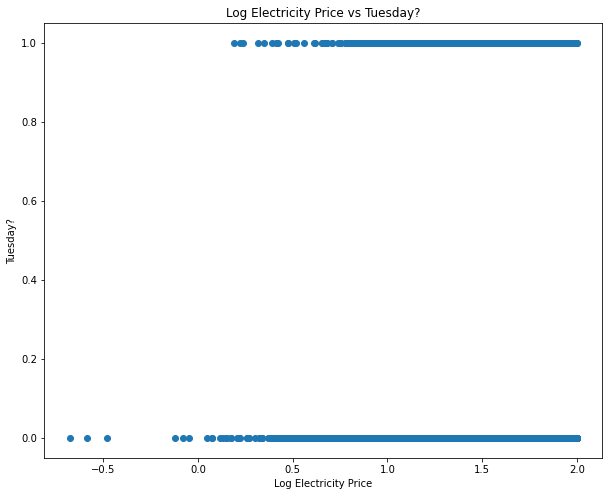

In [207]:
#P-test between EPrice and Tuesday
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Tuesday'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Tuesday'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Tuesday?")
plt.title("Log Electricity Price vs Tuesday?")
    
print("Correlation between Prices and Tuesday: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))



Correlation between Prices and Thursday: 0.01917250157988086
P_value: 0.001875457953031565
Is this relationship significant? Yes


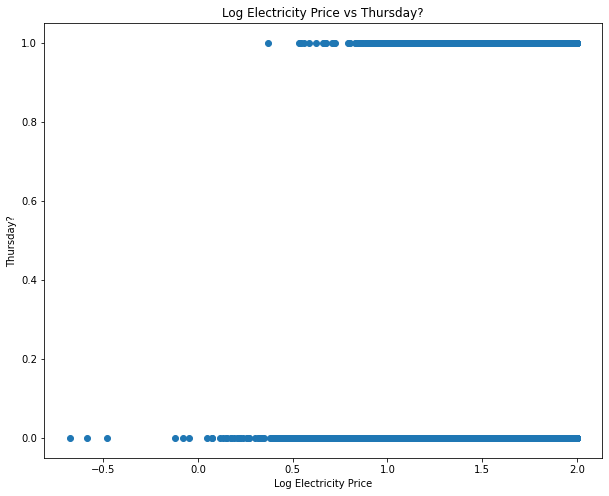

In [208]:
#P-test between EPrice and Thursday
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Thursday'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Thursday'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Thursday?")
plt.title("Log Electricity Price vs Thursday?")
    
print("Correlation between Prices and Thursday: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))


Correlation between Prices and Friday: 0.023249664075906975
P_value: 0.00016282358232297522
Is this relationship significant? Yes


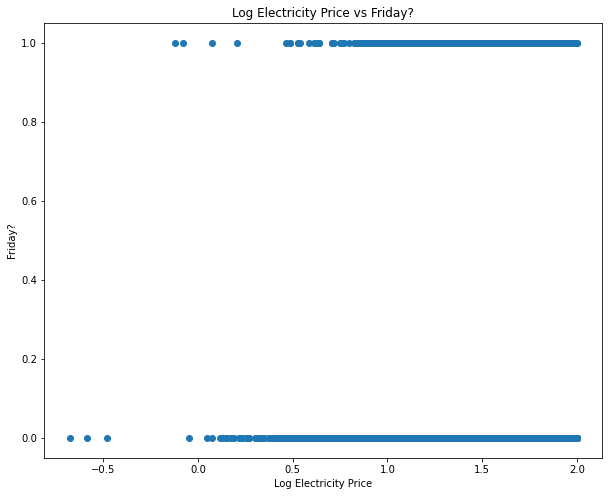

In [209]:
#P-test between EPrice and Friday
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Friday'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Friday'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Friday?")
plt.title("Log Electricity Price vs Friday?")

print("Correlation between Prices and Friday: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))


Correlation between Prices and Saturday: -0.019608234367948115
P_value: 0.0014729798727700708
Is this relationship significant? Yes


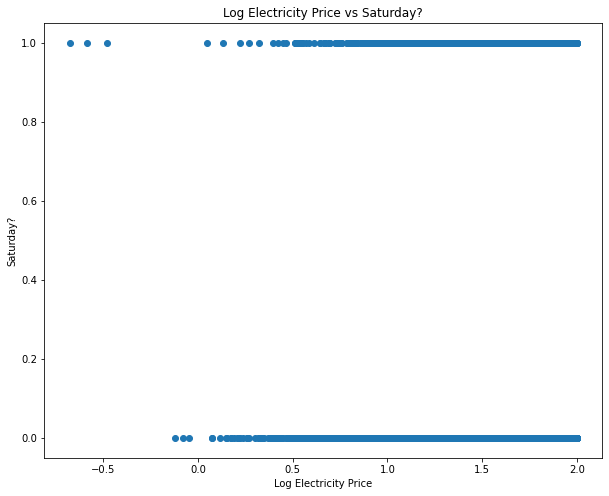

In [210]:
#P-test between EPrice and Saturday
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Saturday'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Saturday'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Saturday?")
plt.title("Log Electricity Price vs Saturday?")

print("Correlation between Prices and Saturday: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))


Correlation between Prices and Sunday: -0.05041869140457353
P_value: 2.814017062271364e-16
Is this relationship significant? Yes


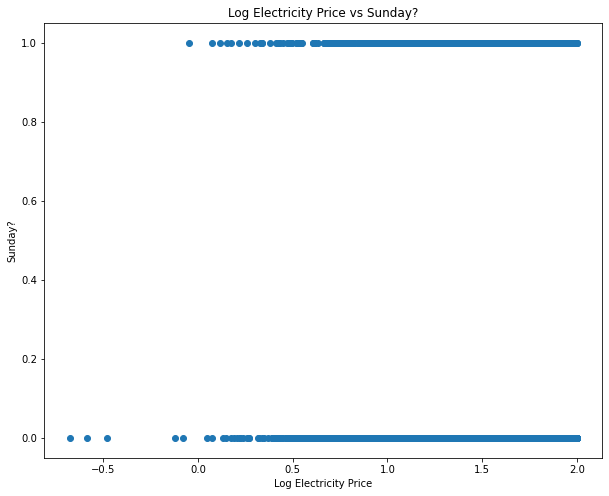

In [211]:
#P-test between EPrice and Sunday
correlation_coefficient, p_value = stats.pearsonr(Houston_electricity_prices_base['EPrice'], Houston_electricity_prices_base['Sunday'])
if (p_value<0.05):
    significant = "Yes"
else:
    significant = "We cannot confirm or disregad the significancy"

plt.figure(figsize=(10, 8))
plt.scatter(Houston_electricity_prices_base['EPrice'],  Houston_electricity_prices_base['Sunday'])

# Add labels and title
plt.xlabel("Log Electricity Price")
plt.ylabel("Sunday?")
plt.title("Log Electricity Price vs Sunday?")

print("Correlation between Prices and Sunday: " + str(correlation_coefficient))
print("P_value: " + str(p_value))
print("Is this relationship significant? " + str(significant))

In [212]:
# Step 10: Retain the variables with statistical significance.

Houston_electricity_prices_base = Houston_electricity_prices_base[['Hour','EPrice','Prev_Price','Week_number','Year','Is_Working_Day','Month','Monday','Friday','Saturday','Sunday']]
Houston_electricity_prices_base

,Hour,EPrice,Prev_Price,Week_number,Year,Is_Working_Day,Month,Monday,Friday,Saturday,Sunday
1,1.0,1.521138,1.401056,52,2022,0,1.0,0,0,1,0
2,2.0,1.409087,1.521138,52,2022,0,1.0,0,0,1,0
3,3.0,1.361917,1.409087,52,2022,0,1.0,0,0,1,0
4,4.0,1.268578,1.361917,52,2022,0,1.0,0,0,1,0
5,5.0,1.105169,1.268578,52,2022,0,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
26297,19.0,1.550228,1.648653,1,2024,1,12.0,0,0,0,0
26298,20.0,1.511482,1.550228,1,2024,1,12.0,0,0,0,0
26299,21.0,1.482159,1.511482,1,2024,1,12.0,0,0,0,0
26300,22.0,1.394627,1.482159,1,2024,1,12.0,0,0,0,0


In [213]:
Houston_electricity_prices_base.dtypes

#We are ready to prepare out train and test datasets

Hour              float64
EPrice            float64
Prev_Price        float64
Week_number        UInt32
Year                int64
Is_Working_Day      int64
Month             float64
Monday              uint8
Friday              uint8
Saturday            uint8
Sunday              uint8
dtype: object

In [214]:
#Step 11: We prepare the training and testing datasets

#Lets calculate three data set sizes

population = Houston_electricity_prices_base.shape[0]
training_size = int(round(population*0.75,0))
testing_size = population - training_size

# Let's shuffle the data and prepare the two sets (training/testing)

Houston_electricity_prices_base = shuffle(Houston_electricity_prices_base)
Houston_electricity_prices_base.reset_index(inplace=True)
electricity_training_data, electricity_test_data = np.split(Houston_electricity_prices_base, [training_size])

# For each set, we will prepare the Y and Xi
y_electricity_training_data = electricity_training_data[['EPrice']]
x_electricity_training_data = electricity_training_data.drop('EPrice', axis=1, inplace=False)
y_electricity_test_data = electricity_test_data['EPrice']
x_electricity_test_data = electricity_test_data.drop('EPrice', axis=1, inplace=False)

#car_data_no_test = pd.concat([car_training_data,car_validation_data], ignore_index=True)
x_electricity_training_data = x_electricity_training_data.drop(labels=['index'], axis=1)
x_electricity_test_data = x_electricity_test_data.drop(labels=['index'], axis=1)

print(type(y_electricity_training_data))
print(y_electricity_training_data.shape)
print(type(x_electricity_training_data))
print(x_electricity_training_data.shape)

<class 'pandas.core.frame.DataFrame'>
(19724, 1)
<class 'pandas.core.frame.DataFrame'>
(19724, 10)


In [215]:
# Step 12: Prepare the Ramdon Forest Approach 

#We set the parameters for the GridSearchCV
params = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#We create the Forest model and optimize it by using GridSearchCV
forest_1 = RandomForestRegressor(oob_score=True, random_state=42)
grid_search = GridSearchCV(estimator=forest_1, param_grid= params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(x_electricity_training_data, y_electricity_training_data)

#We obtain the best model from GridSeachCV and the optimal parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

#We estimate the electricity prices with the optimal forest model, and estimate the RMSE value.
y_pred = best_model.predict(x_electricity_test_data)
forest_RMSE =np.sqrt(mean_squared_error(y_pred,y_electricity_test_data))



In [216]:
#We print the RMSE error value for the Forest model and the parameters for the optimal model.  
print(f'RMSE: {forest_RMSE: .2f}')
print(f'Best parameters of tree: {best_params}')

RMSE:  0.07
Best parameters of tree: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [217]:
#Step 17: Simple test, we will try to predict the ERCOT day ahead electricity price for last Friday (04/18/2025)

date_string = "2025-04-18"
date_object = datetime.strptime(date_string, "%Y-%m-%d").date()
iso_calendar_info = date_object.isocalendar()
week_number = iso_calendar_info[1]
Prev_price = np.log10(26.61)
data = {'Hour': 12, 'Prev_Price': Prev_price, 'Week_number': week_number ,'Year':2025,'Is_Working_Day':1,'Month':4,'Monday':0,'Friday':1,'Saturday':0,'Sunday':0}
x_04182025 = pd.DataFrame([data])

y_04182025 = best_model.predict(x_04182025)

def trunc(num : float, precision :int = 3):
    return float(str(num)[0:precision+2])

In [218]:
print("Estimated electricity price based on Ramdon Forest model on 04/18/2025: US$ " + str(trunc(10**y_04182025[0])))
print("Actual ERCOT electricity price on 04/18/2025: US$ 28.58")

Estimated electricity price based on Ramdon Forest model on 04/18/2025: US$ 31.23
Actual ERCOT electricity price on 04/18/2025: US$ 28.58
